<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 50px">

# Bayesian A/B Testing

<div style="clear: both;"></div>

---

### Learning Objectives
1. Create a Bayesian A/B test
1. Understand the explore/exploit dilemma and how to optimize your experiments

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Background
---

You've just graduated from DSI (congrats!). Your first job is at a startup. 

- Your role: Chief Data Scientist in Charge
- Your salary: Money

Your first task is to design an experiment, testing a new landing page. The current version has the following call to action (CTA):

<a href="https://youtu.be/dQw4w9WgXcQ?t=42" class="btn btn-success">Act Today!</a>

Marketing wants to test another version:

<a href="https://youtu.be/dQw4w9WgXcQ?t=42" class="btn btn-success">Buy now!</a>

Treatment A has been around awhile, and has roughly a 3% conversion rate. 

## Setup
---

All the data for this lecture is fake. We need to randomly generate our parameters for A and B. In reality, these would never be known.

In [2]:
# Remember, you're not supposed to know these!
true_A = .03
true_B = .04

Since we're working exclusively with Beta distributions today, let's create a `np` array for plotting our X axes.

In [3]:
x_axis = np.linspace(0, 1, 1001)

## Priors
---


### Treatment A

As mentioned before, treatment A has roughly a 3% conversion ratio, meaning 3% of visitors to this page will click the button. We want a beta distribution that reflects this ratio, so this will be our prior:

```python
A_alpha = 3
A_beta = 97
A_distn = stats.beta(A_alpha, A_beta)
```

In [4]:
A_alpha = 3
A_beta = 97
A_distn = stats.beta(A_alpha, A_beta)

### Treatment B

A is the champ, B is the challenger. Since we have never released B into the wild, we'll start with a uniform prior:

```python
B_alpha = 1
B_beta = 1
B_distn = stats.beta(B_alpha, B_beta)
```

In [5]:
B_alpha = 1
B_beta = 1
B_distn = stats.beta(B_alpha, B_beta)

## Challenge
---
Plot the two beta distributions in the cell below.

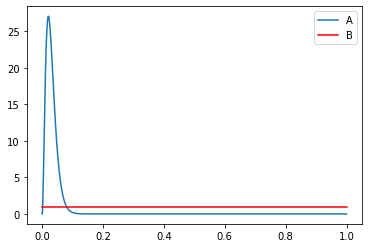

In [6]:
plt.plot(x_axis, A_distn.pdf(x_axis), label='A')
plt.plot(x_axis, B_distn.pdf(x_axis), label='B', color='r')
plt.legend();

## Challenge
---

Because this is fake data, we need to simulate a prospective customer converting with a given probability.

Write a function that takes a probability `p` as a parameter. The function should randomly return 1 with a probability `p` or 0 with a probability `1 - p`.

```python
fake_conversion(.03) # returns a 1 roughly 3% of the time
```

In [7]:
def fake_conversion(p_1):
    return np.random.choice([0, 1], p=[1 - p_1, p_1])

## Simulation

---

Now we will simulate our experiment. Because the entire experiment needs to be run in a `for` loop, the cell below is heavily commented as it will be rather large once we're done.

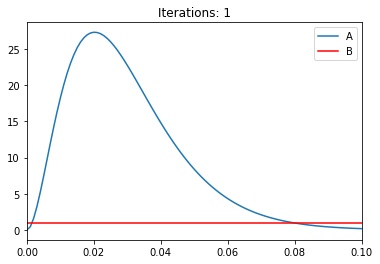

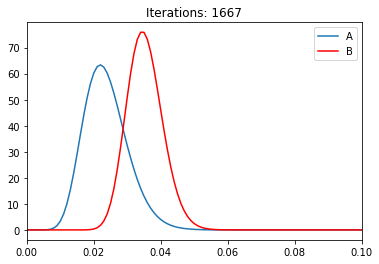

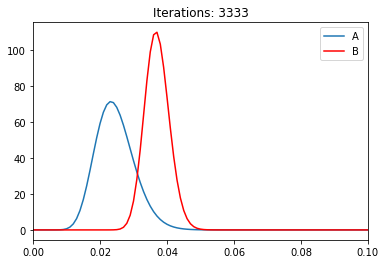

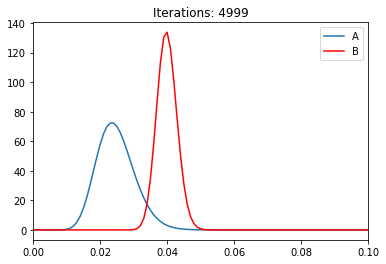

In [8]:
# Set a random seed of 11
np.random.seed(11)

# We're going to run this simulation a lot, so we'll need to
# reset our Beta distributions
A_distn = stats.beta(A_alpha, A_beta)
B_distn = stats.beta(B_alpha, B_beta)

# For each treatment we'll collect the results from our experiment
# Create four counter variables: A_trials, A_conversions, B_trials, B_conversions
A_trials = 0
A_conversions = 0

B_trials = 0
B_conversions = 0

iterations = 5000
for i in range(iterations):
    # Split between A and B
    if A_distn.rvs() >= B_distn.rvs():
#     if i % 2 == 0:
        # Create fake_conversion
        A_test = fake_conversion(true_A)
        # Increment A_trials
        A_trials += 1
        # Increment A_conversions
        A_conversions += A_test
        # Create new beta dist'n
        A_distn = stats.beta(A_alpha + A_conversions, A_beta + A_trials - A_conversions)
    else:
        # Create fake_conversion
        B_test = fake_conversion(true_B)
        # Increment B_trials
        B_trials += 1
        # Increment B_conversions
        B_conversions += B_test
        # Create new beta dist'n
        B_distn = stats.beta(B_alpha + B_conversions, B_beta + B_trials - B_conversions)
    
    # Plot ~3 charts
    if i % (iterations // 3) == 0:
        plt.figure()
        plt.title(f"Iterations: {i+1}")
        plt.plot(x_axis, A_distn.pdf(x_axis), label='A')
        plt.plot(x_axis, B_distn.pdf(x_axis), label='B', color='r')
        plt.legend()
        plt.xlim([0, .1]);

## Sampling from our posteriors

---

Now that we have our posterior distributions, we can sample from each to calculate the probability that B is higher than A.

In [9]:
samples_A = A_distn.rvs(10_000)
samples_B = B_distn.rvs(10_000)

(samples_B > samples_A).mean()

0.9852

## Explore/Exploit dilemma

---

> Suppose you are faced with N slot machines (colourfully called multi-armed bandits). Each bandit has an unknown probability of distributing a prize (assume for now the prizes are the same for each bandit, only the probabilities differ). Some bandits are very generous, others not so much. Of course, you don't know what these probabilities are. By only choosing one bandit per round, our task is devise a strategy to maximize our winnings. - [Bayes Methods for Hackers](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC3.ipynb#Example:-Bayesian-Multi-Armed-Bandits)

In our experiment, we're actually trying to balance two objectives: we want to find out which treatment is better, **while at the same time maximizing revenue**. 


In [10]:
A_revenue = A_conversions * 100
B_revenue = B_conversions * 100

A_revenue, B_revenue, A_revenue + B_revenue

(1600, 17200, 18800)